# Problem description

You are to predict whether a company will go bankrupt in the following year, based on financial attributes of the company.

Perhaps you are contemplating lending money to a company, and need to know whether the company
is in near-term danger of not being able to repay.


## Goal

## Learning objectives

- Demonstrate mastery on solving a classification problem and presenting
the entire Recipe for Machine Learning process in a notebook.
- We will make suggestions for ways to approach the problem
    - But there will be little explicit direction for this task.
- It is meant to be analogous to a pre-interview task that a potential employer might assign
to verify your skill

# Import modules

In [1]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

import os
import math

%matplotlib inline

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import recall_score,precision_score
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline

from sklearn import svm

from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectPercentile
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

from imblearn.over_sampling import SMOTE
# Here I use SMOTE for oversampling, may need to install package by "pip install -U imbalanced-learn"

# API for students

In [2]:
## Load the bankruptcy_helper module

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

# Import bankruptcy_helper module
import bankruptcy_helper
%aimport bankruptcy_helper

helper = bankruptcy_helper.Helper()

# Get the data

The first step in our Recipe is Get the Data.

- Each example is a row of data corresponding to a single company
- There are 64 attributes, described in the section below
- The column `Bankrupt` is 1 if the company subsequently went bankrupt; 0 if it did not go bankrupt
- The column `Id` is a Company Identifier

In [3]:
# Data directory
DATA_DIR = "./Data"

if not os.path.isdir(DATA_DIR):
    DATA_DIR = "../resource/asnlib/publicdata/bankruptcy/data"

data_file = "5th_yr.csv"
data = pd.read_csv( os.path.join(DATA_DIR, "train", data_file) )

target_attr = "Bankrupt"

n_samples, n_attrs = data.shape
print("Date shape: ", data.shape)

Date shape:  (4818, 66)


## Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek

In [4]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
0,0.025417,0.41769,0.0568,1.1605,-126.39,0.41355,0.025417,1.2395,1.16500,0.51773,...,0.049094,0.85835,0.12322,5.6167,7.4042,164.310,2.2214,1.334,0,4510
1,-0.023834,0.2101,0.50839,4.2374,22.034,0.058412,-0.027621,3.6579,0.98183,0.76855,...,-0.031011,1.01850,0.069047,5.7996,7.7529,26.446,13.802,6.4782,0,3537
2,0.030515,0.44606,0.19569,1.565,35.766,0.28196,0.039264,0.88456,1.05260,0.39457,...,0.077337,0.95006,0.25266,15.049,2.8179,104.730,3.4852,2.6361,0,3920
3,0.052318,0.056366,0.54562,10.68,438.2,0.13649,0.058164,10.853,1.02790,0.61173,...,0.085524,0.97282,0,6.0157,7.4626,48.756,7.4863,1.0602,0,1806
4,0.000992,0.49712,0.12316,1.3036,-71.398,0,0.001007,1.0116,1.29210,0.50288,...,0.001974,0.99925,0.019736,3.4819,8.582,114.580,3.1854,2.742,0,1529


# Exploratory Data Analysis

## TARGET variable --> How many company will bankrupt in the following year
### from the graph, we can also know for target variable(bankrupt), the value is either 0 or 1.
### this is an imbalanced set, only 6% will bankrupt next year, let's call them defaulter.
#### solution 1: change performance metric -> recall score
#### solution 2: generate synthetic samples to oversample minority class or undersample majority class
### We can see from the above histogram that our data is imbalanced for 0 and 1. To avoid this problem, we proposed solutions. Since it is worse to misclassify a company that does go bankrupt, and 1 - recall score (TP/FN) measures it, so we want recall score as large as possible. Therefore, we use recall score as scoring method.
### Therefore, we try gradient boosting model, use recall score to compare models, and oversample minority class.

<Figure size 1152x576 with 0 Axes>

Text(0.5, 1.0, 'Distribution of target variable')

Text(0.5, 1.0, 'Count of target variable')

Text(0.5, 0, 'labels')

Text(0, 0.5, 'values')

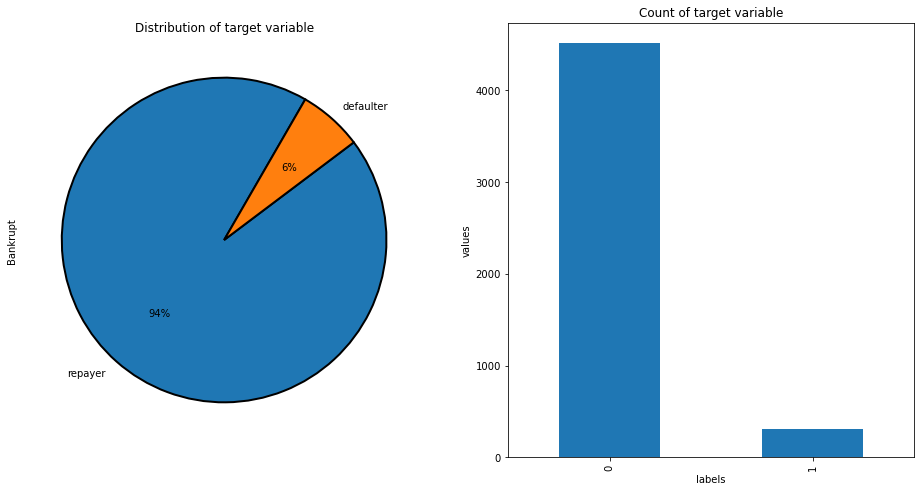

In [5]:
plt.figure(figsize=(16,8))
plt.subplot(121)
data["Bankrupt"].value_counts().plot.pie(autopct = "%1.0f%%",startangle = 60,labels=["repayer","defaulter"],
                                                                        wedgeprops={"linewidth":2,"edgecolor":"black"})
plt.title("Distribution of target variable")
plt.subplot(122)
data["Bankrupt"].value_counts().plot(kind="bar")
plt.title("Count of target variable")
plt.xlabel('labels')
plt.ylabel('values')

## Drop varibale ID because it doesn't effect our target value

In [6]:
data.drop('Id', axis = 1, inplace = True)
print("Date shape: ", data.shape)

Date shape:  (4818, 65)


Pretty *unhelpful* !

What are these mysteriously named features ?

## Description of attributes

This may still be somewhat unhelpful for those of you not used to reading Financial Statements.

But that's partially the point of the exercise
- You can *still* perform Machine Learning *even if* you are not an expert in the problem domain
    - That's what makes this a good interview exercise: you can demonstrate your thought process even if you don't know the exact meaning of the terms
- Of course: becoming an expert in the domain *will improve* your ability to create better models
    - Feature engineering is easier if you understand the features, their inter-relationships, and the relationship to the target

Let's get a feel for the data
- What is the type of each attribute ?


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 65 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4818 non-null   object 
 1   X2        4818 non-null   object 
 2   X3        4818 non-null   object 
 3   X4        4818 non-null   object 
 4   X5        4818 non-null   object 
 5   X6        4818 non-null   object 
 6   X7        4818 non-null   object 
 7   X8        4818 non-null   object 
 8   X9        4818 non-null   float64
 9   X10       4818 non-null   object 
 10  X11       4818 non-null   object 
 11  X12       4818 non-null   object 
 12  X13       4818 non-null   float64
 13  X14       4818 non-null   object 
 14  X15       4818 non-null   object 
 15  X16       4818 non-null   object 
 16  X17       4818 non-null   object 
 17  X18       4818 non-null   object 
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4818 non-null   obje

You may be puzzled:
- Most attributes are `object` and *not* numeric (`float64`)
- But looking at the data via `data.head()` certainly gives the impression that all attributes are numeric

Welcome to the world of messy data !  The dataset has represented numbers as strings.
- These little unexpected challenges are common in the real-word
- Data is rarely perfect and clean

So you might want to first convert all attributes to numeric

**Hint**
- Look up the Pandas method `to_numeric`
    - We suggest you use the option `errors='coerce'`
    

## Convert all object features to numeric
### and check the average interquartile range

In [8]:
df = data.apply(pd.to_numeric, errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 65 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4816 non-null   float64
 1   X2        4816 non-null   float64
 2   X3        4816 non-null   float64
 3   X4        4803 non-null   float64
 4   X5        4808 non-null   float64
 5   X6        4816 non-null   float64
 6   X7        4816 non-null   float64
 7   X8        4804 non-null   float64
 8   X9        4818 non-null   float64
 9   X10       4816 non-null   float64
 10  X11       4816 non-null   float64
 11  X12       4803 non-null   float64
 12  X13       4818 non-null   float64
 13  X14       4816 non-null   float64
 14  X15       4812 non-null   float64
 15  X16       4804 non-null   float64
 16  X17       4804 non-null   float64
 17  X18       4816 non-null   float64
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4744 non-null   floa

In [9]:
df.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt
count,4816.000000,4816.000000,4816.000000,4803.000000,4.808000e+03,4816.000000,4816.000000,4804.000000,4818.000000,4816.000000,...,4818.000000,4816.000000,4818.000000,4816.000000,4.598000e+03,4806.000000,4818.000000,4803.000000,4735.000000,4818.000000
mean,-0.055232,0.533272,0.188992,4.978602,1.956441e+01,-0.070060,-0.042516,5.739985,1.579277,0.503606,...,0.056109,0.022793,0.959585,0.273025,1.108795e+03,11.021303,177.494445,9.287631,38.557533,0.063927
std,6.707351,1.202909,1.282430,100.273952,2.384491e+04,7.778523,6.707970,109.508001,1.342723,4.044036,...,0.755462,7.249022,0.932427,6.338601,7.106563e+04,43.821146,2279.713700,113.225922,588.711967,0.244648
min,-463.890000,0.000000,-72.067000,0.000000,-1.076400e+06,-463.890000,-463.890000,-3.735100,0.000191,-71.444000,...,-46.788000,-468.670000,-0.085920,-184.980000,-1.244000e+01,-0.092493,0.000000,0.000000,-3.726500,0.000000
25%,0.004047,0.254670,0.044923,1.099200,-4.312000e+01,0.000000,0.005985,0.481588,1.015600,0.318990,...,0.011478,0.015574,0.876940,0.000000,5.298300e+00,4.229925,45.065750,3.074350,2.114850,0.000000
50%,0.046487,0.451495,0.218560,1.642300,3.673450e-01,0.000000,0.056685,1.149000,1.140500,0.522325,...,0.053663,0.108940,0.950825,0.006320,9.038900e+00,6.176800,73.879500,4.928700,4.077200,0.000000
75%,0.116730,0.662178,0.420153,2.929200,4.986775e+01,0.110470,0.136025,2.781300,1.814050,0.721823,...,0.124030,0.240262,0.990358,0.206915,1.720750e+01,9.302800,118.597500,8.067850,9.187600,0.000000
max,2.352300,72.416000,28.336000,6845.800000,1.250100e+06,203.150000,2.352300,6868.500000,37.807000,266.860000,...,1.000000,87.981000,47.788000,308.150000,4.818700e+06,1308.500000,127450.000000,7641.300000,28999.000000,1.000000


### Check extreme and drop outliers

In [10]:
train_std = df.describe().loc['std',:]
extreme = train_std[train_std>10000].index.values
regular = [col for col in df.columns[:-1] if col not in extreme]

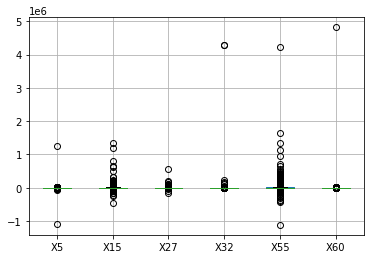

In [11]:
df.loc[:,extreme].boxplot()

In [12]:
df['X32'].describe()

count    4.776000e+03
mean     2.074823e+03
std      8.766498e+04
min      0.000000e+00
25%      4.992400e+01
50%      8.123350e+01
75%      1.301050e+02
max      4.277200e+06
Name: X32, dtype: float64

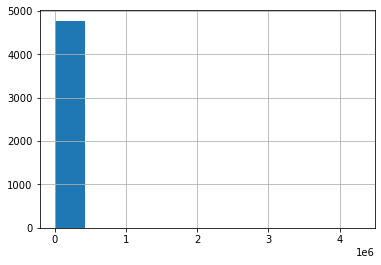

In [13]:
df['X32'].hist()

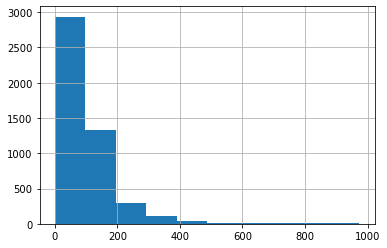

In [14]:
median32 = df.loc[df['X32']<1000, 'X32'].median()
df['X32'] = np.where(df['X32'] >1000, median32,df['X32'])
df['X32'].hist()

In [15]:
df['X55'].describe()

count    4.818000e+03
mean     1.074023e+04
std      8.284685e+04
min     -1.118500e+06
25%      9.771450e+01
50%      1.829500e+03
75%      7.786950e+03
max      4.212200e+06
Name: X55, dtype: float64

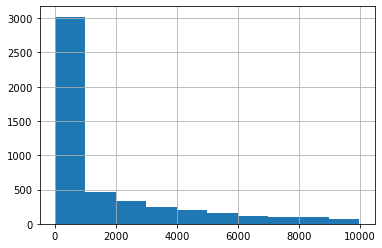

In [16]:
median55 = df.loc[df['X55']<10000, 'X55'].median()
df['X55'] = np.where(df['X55'] >10000, median55,df['X55'])
df['X55'] = np.where(df['X55'] < 0, median55,df['X55'])
df['X55'].hist()

In [17]:
df['X60'].describe()

count    4.598000e+03
mean     1.108795e+03
std      7.106563e+04
min     -1.244000e+01
25%      5.298300e+00
50%      9.038900e+00
75%      1.720750e+01
max      4.818700e+06
Name: X60, dtype: float64

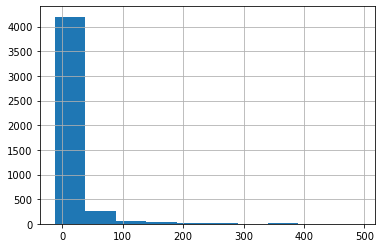

In [18]:
median60 = df.loc[df['X60']<500, 'X60'].median()
df['X60'] = np.where(df['X60'] >500, median60,df['X60'])
df['X60'].hist()

#### From above boxplots, we know most variables are normally distributed but some have large standard deviations and ranges, such as X32, X60, etc. It might be a good idea to eliminate outliers (companies) that have extreme values on these variables

## Missing value
check if there are any missing value in dataset

In [19]:
df.isnull().any()

X1           True
X2           True
X3           True
X4           True
X5           True
            ...  
X61          True
X62         False
X63          True
X64          True
Bankrupt    False
Length: 65, dtype: bool

In [20]:
# Function to calculate missing values by column
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * mis_val /len(df)
    # Make a table with the results 
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0: 'Missing Values Number', 1: '% of Missing'})
    # Sort the table by % of Missing, descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1]!=0].sort_values(
    '% of Missing', ascending = False). round(2)
    #print some summart info
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n" 
         + "There are " + str(mis_val_table_ren_columns.shape[0]) +
         "columns with missing values.")
    
    return mis_val_table_ren_columns

In [21]:
# Missing Values Stat
missing_values = missing_values_table(df)
missing_values.head(10)

Your selected dataframe has 65 columns.
There are 48columns with missing values.


,Missing Values Number,% of Missing
X37,2068,42.92
X27,305,6.33
X60,220,4.57
X45,220,4.57
X24,116,2.41
X64,83,1.72
X54,83,1.72
X53,83,1.72
X28,83,1.72
X21,74,1.54


In [22]:
# Since only feature X37 has over 40% of missing value, we delete this feature.
df.drop('X37', axis = 1, inplace = True)
print("Data shape: ", df.shape)

Data shape:  (4818, 64)


### Missing value imputation and scaling
#### a) Imputer: Impute missing value by median
#### b) Scaler: Standardize and align the units between feature variables
### Using a pipeline to make multiple processes performed at once.

In [23]:
pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median", missing_values=np.nan)),
    ("scaler", StandardScaler()),
])

In [24]:
target = 'Bankrupt'
X = pipe.fit_transform(df.drop(target, axis=1))
y = df[target].values

### Tried PCA, but it seems not improve model

## Applied upsampling method and Split dataset into train set and test set
### Since we have an imbalanced dataset, we have to to oversample the examples in the minority class. Here I used SMOTE(Synthetic Minority Oversampling Technique) to do so.
### Though it can also be achieved by simply duplicating examples from the minority class in the training dataset prior to fitting a model, it can only balance the class distribution but does not provide any additional information to the model.
### However with SMOTE,it can synthesize new examples from the minority class. This is a type of data augmentation for tabular data and can be very effective.

In [25]:
def upsampling_minority(X, y):
    # setting up testing and training sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42,stratify=y)
    
    print('Before upsampling: training data shape', X_train.shape, 'test data shape', X_test.shape)
    print("Unbalanced training data{}".format({n: v for n, v in zip(['Not Bankrupt', 'Bankrupt'], np.bincount(y_train))}))
    
    sm = SMOTE(random_state=10)
    X_train, y_train = sm.fit_resample(X_train, y_train)
   
    print('Finished upsampling: training data shape', X_train.shape, 'test data shape', X_test.shape)
    print("Balanced training data {}".format({n: v for n, v in zip(['Not Bankrupt', 'Bankrupt'], np.bincount(y_train))}))
    
    return X_train, X_test, y_train, y_test

In [26]:
X_train, X_test, y_train, y_test = upsampling_minority(X, y)

Before upsampling: training data shape (4095, 63) test data shape (723, 63)
Unbalanced training data{'Not Bankrupt': 3833, 'Bankrupt': 262}
Finished upsampling: training data shape (7666, 63) test data shape (723, 63)
Balanced training data {'Not Bankrupt': 3833, 'Bankrupt': 3833}


# Date Processing

### Prepare the data and Classifier
#### I tried different paramenters in LogisticRegression and find best paramaters for this LR Classifier

In [27]:
#  Create a StandardScaler object
scaler = StandardScaler()

## Classification Model
#  Create a classifier
# clf: sklearn classifier
# name: name of your classifier
clf = LogisticRegression(penalty='l2',solver='liblinear',C=0.0001)
name = "Logistic Classifier"
#train_samples = X_train.shape[0]

pre_pip = Pipeline(steps = [('scaler', scaler)])
model_pipeline = Pipeline(steps = [('transform',pre_pip),('classify',clf)])

## Train Model

In [28]:
# score_in_sample: a scalar number, score for in-sample examples
_ = model_pipeline.fit(X_train, y_train)
score_in_sample = accuracy_score(model_pipeline.predict(X_train), y_train)

print("Model: {m:s} in sample score={s:3.2f}\n".format(m=name, s=score_in_sample))

Model: Logistic Classifier in sample score=0.73



## Train the model using 5-fold Cross Validation

In [29]:
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=5) # Check 5-fold cross validation score

print("Model: {m:s} avg cross validation score={s:3.2f}\n".format(m=name, s=cross_val_scores.mean()) )

Model: Logistic Classifier avg cross validation score=0.71



### Calculate the number of parameters in model. Report only the number of non-intercept parameters.

In [30]:
#clf = clf["classify"]
num_parameters = clf.coef_[0].shape

print("\nShape of intercept: {i}; shape of coefficients: {c}".format(i=clf.intercept_.shape,
                                                                   c=num_parameters) )


Shape of intercept: (1,); shape of coefficients: (63,)


#### Show coefficients distribution  -->roughly normal distribution

[[-0.00657711  0.0293393  -0.02944378 -0.01034528 -0.01036125 -0.0073084
  -0.00666619 -0.01171413  0.03548689 -0.00271011 -0.00652242 -0.03391103
  -0.00436447 -0.00666675 -0.00185011 -0.04955212 -0.01178625 -0.00686672
   0.00254147  0.01239083 -0.01025961 -0.00646068  0.0028462  -0.00750836
  -0.00406903 -0.0478527  -0.0081589  -0.00450229 -0.07688949  0.00463185
   0.00390626  0.06525831  0.01082053  0.00041756 -0.00693123  0.00660882
  -0.0027626  -0.03227109 -0.00020342 -0.00645844  0.00256928  0.01177
   0.01031047 -0.0036984  -0.00959819  0.00040231 -0.00575977  0.00311564
  -0.01682929  0.02767944  0.01185413  0.00259605  0.00272783 -0.07312371
  -0.02778619 -0.00584933  0.01680136  0.00887187  0.00679384  0.00532113
   0.00939697  0.00627981  0.00237363]]
[0.00024594]


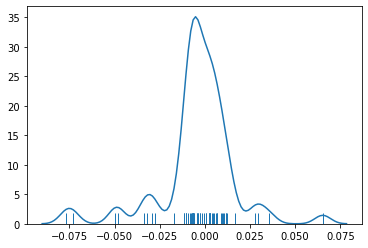

In [31]:
coe = clf.coef_
print(coe)
print(clf.intercept_)

# Plot distribution of coefficients to find pattern
sns.distplot(coe, rug=True, hist=False)

In [32]:
# Set variable to store the model accuracy on the test set
score_out_of_sample = accuracy_score(clf.predict(X_test), y_test)

print("Model: {m:s} out-of-sample score={s:3.2f}\n".format(m=name, s=score_out_of_sample))

Model: Logistic Classifier out-of-sample score=0.57



## Compare the models: LR, Random Forest, Svm and Gradient boosting
### By calculating accuracy(both in sample and out sample),recall, precision, and plot precision-recall curve for each model

In [33]:
def find_score(model,nam,X_train,X_test):
    _=model.fit(X_train, y_train)
    score_in = accuracy_score(model.predict(X_train), y_train)
    print("Model: {m:s} in sample score={s:3.2f}\n".format(m= nam, s=score_in))

    score_out = accuracy_score(model.predict(X_test), y_test)
    print("Model: {m:s} out-of-sample score={s:3.2f}\n".format(m= nam, s=score_out))

    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred, pos_label=1, average="binary")
    precision = precision_score(y_test, y_pred, pos_label=1, average="binary")
    print("Model: {m:s} recall score={s:3.2f}\n".format(m= nam, s=recall))
    print("Model: {m:s} precision score={s:3.2f}\n".format(m= nam, s=precision))
    
    #average_precision = average_precision_score(y_test, y_pred)
    disp = plot_precision_recall_curve(model, X_test, y_test)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(precision))

In [34]:
# Random forest
rf = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, 
                            min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None,
                            bootstrap=True, oob_score=False, n_jobs=1, random_state=42, verbose=0)

Model: random forest in sample score=1.00

Model: random forest out-of-sample score=0.92

Model: random forest recall score=0.41

Model: random forest precision score=0.37



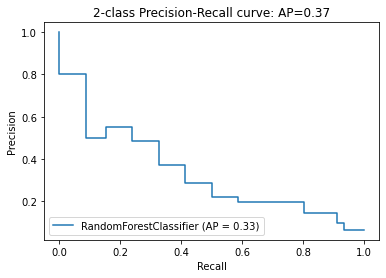

In [35]:
find_score(rf,'random forest',X_train,X_test)

### Used Feature importance to select features

In [36]:
feature_name = pd.DataFrame()
feature_name['feature'] = df.columns[0:-1]
feature_name['feature importance'] = rf.feature_importances_
feature_name = feature_name.sort_values(by = "feature importance",ascending = False)
feature_name

,feature,feature importance
37,X39,0.089079
34,X35,0.071889
44,X46,0.037639
25,X26,0.037028
26,X27,0.035576
...,...,...
48,X50,0.006285
46,X48,0.005629
6,X7,0.005421
60,X62,0.004086


In [37]:
my_list = feature_name['feature'][0:35]
X_train_df = pd.DataFrame(data = X_train, columns = df.columns[0:-1])
X_train_new = X_train_df.loc[:,my_list]
X_train_new

X_test_df = pd.DataFrame(data = X_test, columns = df.columns[0:-1])
X_test_new = X_test_df.loc[:,my_list]
X_test_new

,X39,X35,X46,X26,X27,X38,X42,X19,X18,X6,...,X47,X9,X64,X44,X56,X1,X59,X22,X40,X8
0,0.043546,0.021055,-0.018635,-0.015527,-0.036193,-0.012538,0.025608,0.023651,0.022002,0.053752,...,-0.041659,-0.394223,-0.049421,-0.017420,-0.011239,0.021780,-0.043069,0.020702,-0.023961,-0.037713
1,0.058895,0.020238,-0.025499,-0.026274,-0.035775,-0.032099,0.029769,0.023007,0.017258,0.009006,...,-0.030852,0.088280,0.044364,0.083663,0.010089,0.018424,-0.043069,0.019687,-0.033531,-0.044591
2,-0.038655,0.000208,-0.031191,-0.026911,-0.036258,-0.029153,0.001836,0.015108,0.005785,0.030350,...,-0.021370,-0.475476,-0.043032,0.008021,-0.157422,0.009429,-0.043069,-0.000141,-0.033822,-0.044172
3,0.079958,0.024087,-0.031586,-0.025168,-0.035801,-0.015046,0.036251,0.025332,0.020254,0.018143,...,-0.033722,0.059380,-0.058958,-0.026543,0.031193,0.020964,0.022637,0.023812,-0.033552,-0.046930
4,0.036838,0.027266,-0.006099,0.010089,-0.036199,0.046762,0.023668,0.022858,0.028278,0.054482,...,-0.038059,-0.397649,-0.049605,-0.084572,-0.016833,0.027319,-0.043069,0.026911,-0.015427,-0.004062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7661,0.611905,0.016735,-0.040636,-0.029522,-0.036189,-0.553370,0.189374,0.050086,0.009933,-0.217806,...,-0.042221,-1.034323,-0.064681,-0.127090,0.585746,0.013616,-0.043069,0.016331,-0.034687,-0.058061
7662,-0.447364,-0.030746,-0.038439,-0.033557,-0.036527,-0.175798,-0.128357,-0.054272,-0.032883,-0.057120,...,-0.024534,-0.708583,-0.063346,-0.048554,-0.490023,-0.028914,0.191936,-0.033614,-0.033911,-0.054301
7663,-0.114578,-0.026990,-0.038895,-0.038602,-0.036148,-0.024892,-0.020120,-0.000187,-0.029266,-0.020373,...,-0.040346,-0.478887,-0.059474,-0.119451,-0.164358,-0.025840,-0.014182,-0.027332,-0.034998,-0.045180
7664,-0.136450,0.009224,0.039953,0.015893,-0.029030,0.026923,0.251753,0.125686,0.074001,-0.008409,...,-0.024249,-0.623381,-0.032791,-0.061333,-0.183895,0.060482,-0.043069,0.078170,0.031683,-0.022437


,X39,X35,X46,X26,X27,X38,X42,X19,X18,X6,...,X47,X9,X64,X44,X56,X1,X59,X22,X40,X8
0,0.000163,0.005245,-0.019418,-0.019013,-0.034727,0.066068,0.036396,0.028000,0.013612,0.069593,...,-0.012503,-0.602917,-0.062985,-0.065145,-0.048754,0.008231,-0.042955,0.012443,-0.027507,0.001697
1,-0.041655,0.001553,-0.039634,-0.029879,-0.036261,-0.118213,0.000969,0.001189,-0.002738,-0.018082,...,-0.022822,-0.479931,-0.063562,-0.068294,-0.166412,-0.001200,-0.043069,0.001205,-0.034790,-0.051131
2,0.065214,0.019792,-0.034497,-0.021405,-0.036175,-0.013009,0.031874,0.024765,0.018377,0.049196,...,-0.029479,-0.382454,-0.060104,-0.060332,0.007420,0.022110,-0.039901,0.019439,-0.033246,-0.041731
3,0.025836,0.021134,-0.036616,-0.026466,-0.036051,-0.099004,0.026693,0.019390,0.017457,0.009006,...,-0.035642,1.012915,-0.054577,-0.080975,-0.023032,0.021183,-0.400531,0.028446,-0.034888,-0.053569
4,0.017209,0.011002,-0.024734,-0.026791,-0.036215,0.026227,0.017992,0.017083,0.008391,0.017629,...,-0.029624,-0.412471,-0.057448,-0.009422,-0.041396,0.011068,0.047772,0.010651,-0.031934,-0.044811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718,0.127102,0.036129,-0.014525,-0.016781,-0.031943,0.009664,0.048055,0.033403,0.033898,0.009006,...,-0.024355,0.161348,-0.022795,0.004864,0.078425,0.031818,-0.043069,0.034480,-0.025898,-0.036914
719,0.137091,0.031170,-0.029928,-0.019537,-0.033488,-0.047958,0.077684,0.045793,0.043137,0.009006,...,-0.042255,-0.108132,-0.057758,0.090610,0.088434,0.039669,-0.043069,0.045892,-0.034698,-0.046385
720,0.094872,0.030492,-0.033367,-0.023080,-0.036149,-0.027200,0.040450,0.027554,0.026031,0.044729,...,-0.029776,-0.368005,-0.056793,-0.034070,0.029658,0.025197,-0.027222,0.030136,-0.034878,-0.045278
721,0.038838,0.012357,-0.023640,-0.026605,-0.036076,0.019514,0.023981,0.020464,0.011038,0.009006,...,-0.013905,-0.269240,-0.044247,0.068019,-0.010005,0.013344,-0.035590,0.011870,-0.031314,-0.036267


## Compare models

Model: random forest in sample score=1.00

Model: random forest out-of-sample score=0.93

Model: random forest recall score=0.52

Model: random forest precision score=0.46



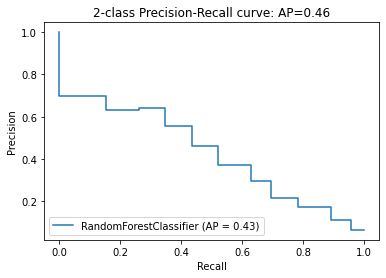

In [38]:
find_score(rf,'random forest',X_train_new,X_test_new)

Model: logistic regression in sample score=0.70

Model: logistic regression out-of-sample score=0.69

Model: logistic regression recall score=0.74

Model: logistic regression precision score=0.14



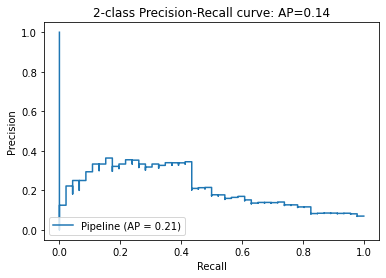

In [39]:
find_score(model_pipeline,'logistic regression',X_train_new,X_test_new)

In [40]:
# SVM model
clf = make_pipeline(StandardScaler(),SVC(kernel='linear',C=0.1))

Model: svm in sample score=0.78

Model: svm out-of-sample score=0.75

Model: svm recall score=0.83

Model: svm precision score=0.18



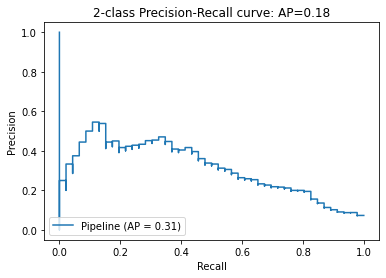

In [41]:
find_score(clf,'svm',X_train_new,X_test_new)

In [42]:
# Gradient Boosting model
gbm = GradientBoostingClassifier(random_state=42)

Model: gbm in sample score=0.95

Model: gbm out-of-sample score=0.90

Model: gbm recall score=0.72

Model: gbm precision score=0.36



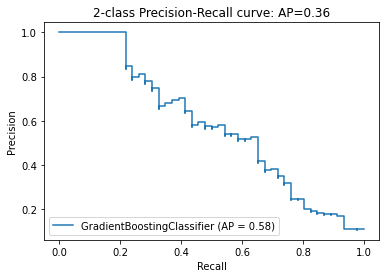

In [43]:
find_score(gbm,'gbm',X_train_new,X_test_new)

# Choose Model ---> Gradient Boosting Model is the best
### Since it is much more important to detect bankruptcy, we want a higher recall, but we also want good accuracy and precision. 
### According to the scores we calculated for each of the four models, we found that SVM,Gradient Boosting,and logistic regression model have high recall score; meanwhile random forest and gradient boosting have high accuracy and precision.
### Therefore, we choose Gradient Boosting Model as final model for it is in the intersection of models with great recall, accuracy and precision.

# Evaluating your project

We will evaluate your submission on a test dataset that we provide
- It has no labels, so **you** can't use it to evaluate your model, but **we** have the labels
- We will call this evaluation dataset the "holdout" data

Let's get it

In [44]:
holdout_data = pd.read_csv( os.path.join(DATA_DIR, "holdout", '5th_yr.csv') )

print("Data shape: ", holdout_data.shape)


Data shape:  (1092, 65)


We will evaluate your model on the holdout examples using metrics
- Accuracy
- Recall
- Precision

From our lecture: we may have to make a trade-off between Recall and Precision.

Our evaluation of your submission will be partially based on how you made (and described) the trade-off.

You may assume that it is 5 times worse to *fail to identify a company that will go bankrupt*
than it is to fail to identify a company that won't go bankrupt.

# Your model

Time for you to continue the Recipe for Machine Learning on your own.



## Submission guidelines

Although your notebook may contain many models (e.g., due to your iterative development)
we will only evaluate a single model.
So choose one (explain why !) and do the following.

- You will implement the body of a subroutine `MyModel`
    - That takes as argument a Pandas DataFrame 
        - Each row is an example on which to predict
        - The features of the example are elements of the row
    - Performs predictions on each example
    - Returns an array or predictions with a one-to-one correspondence with the examples in the test set
    

**Remember**

The holdout data is in the same format as the one we used for training
- Except that it has no attribute for the target
- So you will need to perform all the transformations on the holdout data
    - As you did on the training data
    - Including turning the string representation of numbers into actual numeric data types

All of this work *must* be performed within the body of the `MyModel` routine you will write

We will grade you by comparing the predictions array you create to the answers known to us.

# My Model

In [45]:

import pandas as pd
import os

# Input X is a dataframe and output prediction is an array(0 or 1)
def MyModel(X):
    # It should create an array of predictions; we initialize it to the empty array for convenience
    X.drop(['Id','X37'], axis = 1, inplace = True) #drop feature "Id" and "X37" which has most missing values
    df_test = X.apply(pd.to_numeric, errors='coerce') # Transform all features to be numeric
    
    # Dimension Reduction by feature importance, my list is 
    X_test_try = pipe.fit_transform(df_test)
    X_test = pd.DataFrame(data = X_test_try, columns = df.columns[0:-1])
    X_test_holdout = X_test.loc[:,my_list]
    
    gbm = GradientBoostingClassifier(random_state=42)
    _=gbm.fit(X_train_new, y_train)

    predictions=[]
    predictions = gbm.predict(X_test_holdout)
    
    return predictions

result = MyModel(holdout_data)
print(result.shape)

(1092,)


In [46]:
from collections import Counter
Counter(result)

Counter({0: 696, 1: 396})

# Check my work

In [47]:
data = pd.read_csv( os.path.join(DATA_DIR, "train", data_file) )

In [48]:
print(data['Bankrupt'].shape)

(4818,)


In [49]:
test = data['Bankrupt']
test

0       0
1       0
2       0
3       0
4       0
       ..
4813    0
4814    0
4815    0
4816    0
4817    0
Name: Bankrupt, Length: 4818, dtype: int64

In [50]:
name = "Gradient Boosting model"
data = pd.read_csv( os.path.join(DATA_DIR, "train", data_file) )
data.drop('Bankrupt', axis = 1, inplace = True)
y_test_pred = MyModel(data)
accuracy_test = accuracy_score(test, y_test_pred)
recall_test = recall_score(test, y_test_pred, pos_label=1, average="binary")
precision_test = precision_score(test, y_test_pred, pos_label=1, average="binary")
print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name,
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            p=precision_test
                                                                            )
         )


	Gradient Boosting model Accuracy: 93.5%, Recall 86.0%, Precision 49.4%
